In [1]:
import numpy as np
import pandas as pd
import datetime
import re
import emojis
import string

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('fivethirtyeight')
%matplotlib inline

from collections import Counter
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [2]:
tweet_df = pd.read_csv('data/twitter_data/galaxys_edge.csv', 
                       usecols = ['tweet', 'date'])

tweet_df

,date,tweet
0,2020-07-15,"Radio Batuu broadcasts Star Wars music, news a..."
1,2020-07-15,Entrance to Rise of the Resistance at 10:30am....
2,2020-07-15,The moment I saw this my mouth dropped open an...
3,2020-07-15,4 months later and this hunk of junk is still ...
4,2020-07-15,Headed to #GalaxysEdge this morning for the #d...
...,...,...
43153,2019-10-17,I love Galaxy’s Edge a ton and a lot of that l...
43154,2019-10-17,This childless millennial thing has really mad...
43155,2019-10-17,I don’t think I could take more of a perfect s...
43156,2019-10-17,Star Wars Galaxy’s Edge: A Crash of Fate Book ...


In [3]:
tweet_df['tweet'][0].split()

['Radio',
 'Batuu',
 'broadcasts',
 'Star',
 'Wars',
 'music,',
 'news',
 'and',
 'sports',
 'in',
 'Disneyland’s',
 'Galaxy’s',
 'Edge',
 'https://www.ocregister.com/2020/07/15/radio-batuu-broadcasts-star-wars-music-news-and-sports-about-disneylands-galaxys-edge/',
 '…',
 '@Disneyland',
 '@starwars',
 '#galaxysedge']

In [4]:
def PreProcessBasic(t):
  tList = t.split()
  if 'RT' in tList:
    tList.remove('RT')
  for item in tList:
    if item[0]=='@':
      tList.remove(item)  
  return ' '.join(tList)

In [5]:
tweet_df['tweet'] = tweet_df['tweet'].apply(PreProcessBasic)

tweet_df.head()

,date,tweet
0,2020-07-15,"Radio Batuu broadcasts Star Wars music, news a..."
1,2020-07-15,Entrance to Rise of the Resistance at 10:30am....
2,2020-07-15,The moment I saw this my mouth dropped open an...
3,2020-07-15,4 months later and this hunk of junk is still ...
4,2020-07-15,Headed to #GalaxysEdge this morning for the #d...


In [6]:
tweet_df['tweet'] = tweet_df['tweet'].str.lower()

tweet_df.head()

,date,tweet
0,2020-07-15,"radio batuu broadcasts star wars music, news a..."
1,2020-07-15,entrance to rise of the resistance at 10:30am....
2,2020-07-15,the moment i saw this my mouth dropped open an...
3,2020-07-15,4 months later and this hunk of junk is still ...
4,2020-07-15,headed to #galaxysedge this morning for the #d...


In [7]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [8]:
PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [9]:
tweet_df['tweet'] = tweet_df['tweet'].apply(remove_punctuation)

tweet_df.head()

,date,tweet
0,2020-07-15,radio batuu broadcasts star wars music news an...
1,2020-07-15,entrance to rise of the resistance at 1030am h...
2,2020-07-15,the moment i saw this my mouth dropped open an...
3,2020-07-15,4 months later and this hunk of junk is still ...
4,2020-07-15,headed to galaxysedge this morning for the dis...


In [10]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [11]:
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])

In [12]:
tweet_df['tweet'] = tweet_df['tweet'].apply(remove_stopwords)
tweet_df['tweet'].head()

0    radio batuu broadcasts star wars music news sp...
1    entrance rise resistance 1030am hollywoodstudi...
2    moment saw mouth dropped open seven years old ...
3    4 months later hunk junk still sitting herefee...
4    headed galaxysedge morning disneyworldreopenin...
Name: tweet, dtype: object

In [13]:
count = Counter()

for text in tweet_df['tweet'].values:
    for word in text.split():
        count[word] += 1
count.most_common(25)

[('galaxysedge', 42697),
 ('starwars', 20818),
 ('…', 13738),
 ('disneyland', 10909),
 ('star', 8402),
 ('disney', 8376),
 ('wars', 8147),
 ('riseoftheresistance', 7553),
 ('edge', 6775),
 ('batuu', 6201),
 ('disneyworld', 5203),
 ('waltdisneyworld', 4536),
 ('hollywoodstudios', 4431),
 ('resistance', 4309),
 ('rise', 3994),
 ('galaxys', 3915),
 ('wdw', 3669),
 ('new', 2700),
 ('galaxy’s', 2639),
 ('today', 2568),
 ('day', 2400),
 ('ride', 2259),
 ('starwarsgalaxysedge', 2215),
 ('get', 2172),
 ('–', 2150)]

In [14]:
new_stopwords = ['galaxysedge','starwars', 'disneyland', 'disney','…', 'star', 'wars', 'edge', 'disneyworld', 'hollywoodstudios', 'galaxys', "galaxy's", 'starwarsgalaxysedge', 'wdw', 'waltdisneyworld', "galaxy’s", '–', 'disneyparks', 'hollywood', 'blackspireoutpost', 'galaxy', 'riseoftheresistance']
stopwords.extend(new_stopwords)

In [15]:
tweet_df['tweet'] = tweet_df['tweet'].apply(remove_stopwords)
tweet_df['tweet'].head()

0    radio batuu broadcasts music news sports disne...
1    entrance rise resistance 1030am pictwittercomg...
2    moment saw mouth dropped open seven years old ...
3    4 months later hunk junk still sitting herefee...
4    headed morning disneyworldreopening dont forge...
Name: tweet, dtype: object

In [16]:
count = Counter()

for text in tweet_df['tweet'].values:
    for word in text.split():
        count[word] += 1
count.most_common(25)

[('batuu', 6201),
 ('resistance', 4309),
 ('rise', 3994),
 ('new', 2700),
 ('today', 2568),
 ('day', 2400),
 ('ride', 2259),
 ('get', 2172),
 ('time', 2076),
 ('lightsaber', 2036),
 ('first', 1894),
 ('one', 1841),
 ('got', 1701),
 ('falcon', 1672),
 ('like', 1638),
 ('back', 1527),
 ('go', 1490),
 ('boarding', 1486),
 ('see', 1357),
 ('droid', 1267),
 ('cantina', 1205),
 ('it’s', 1196),
 ('experience', 1192),
 ('millennium', 1191),
 ('studios', 1173)]

In [17]:
count.most_common()[:-25:-1]

[('pictwittercom5saghqnpmn', 1),
 ('pictwittercomcoa9af5zcz', 1),
 ('nestor', 1),
 ('httpswwwinstagramcompb32s8dihqbxigshid1w03rqxlt7810', 1),
 ('httpswwwinstagramcompb3427lxnr0migshid1mt6hserhyz85', 1),
 ('httpswwwinstagramcompb37xrbbgs8igshid4ovzro4tca7a', 1),
 ('httpswwwinstagramcompb5d8f2lawwoigshid3x6vwy9sh249', 1),
 ('r8n8', 1),
 ('httpswwwinstagramcompb5d82ycgy5iigshidkvm8pta705wp', 1),
 ('httpswwwinstagramcompb5d9mljaorkigshid1qk4rnvrmj132', 1),
 ('pictwittercomx6theirjjs', 1),
 ('sunny', 1),
 ('nightcap', 1),
 ('httpswwwinstagramcompb5wqr6fhdqnigshid111osbhrindka', 1),
 ('httpswwwinstagramcompb53fhmpgqwzigshid66gp0iaxz2y1', 1),
 ('mrstormtrooperdavis', 1),
 ('pictwittercomrojeiy8ypd', 1),
 ('“endgame”', 1),
 ('butthey’re', 1),
 ('pictwittercom9u1lveho5b', 1),
 ('pictwittercomwdqkyzpjqb', 1),
 ('queenamidala', 1),
 ('snac', 1),
 ('attac', 1)]

In [18]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [19]:
def convert_emoticons(text):
  for emot in EMOTICONS:
      text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
  return text

In [20]:
tweet_df['tweet'] = tweet_df['tweet'].apply(convert_emoticons)

In [21]:
tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: emojis.decode(x))

In [22]:
tweet_df[tweet_df['tweet'].str.find(':')!=-1]

,date,tweet
5,2020-07-15,:thinking:a woke reboot lucasfilm attempted th...
8,2020-07-14,soms ogas getting cut right matt wouldnt want ...
22,2020-07-14,:mask: there’s relaxation station right market...
28,2020-07-13,welcome new family member r2l4:black_heart: th...
29,2020-07-13,custom kyber crystal crafted cores shout refer...
...,...,...
43122,2019-10-17,imagineer takes us walk riseoftheresistances g...
43128,2019-10-17,still uses inuniverse names meals :grinning: p...
43129,2019-10-17,well cool dad surprised yet first day trip wor...
43138,2019-10-17,recently saw two trekwars fans dressed starfle...


In [23]:
tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: x.replace(':',' '))

In [24]:
tweet_df[tweet_df['tweet'].str.find(':')!=-1]

,date,tweet


In [25]:
tweet_df.head()

,date,tweet
0,2020-07-15,radio batuu broadcasts music news sports disne...
1,2020-07-15,entrance rise resistance 1030am pictwittercomg...
2,2020-07-15,moment saw mouth dropped open seven years old ...
3,2020-07-15,4 months later hunk junk still sitting herefee...
4,2020-07-15,headed morning disneyworldreopening dont forge...


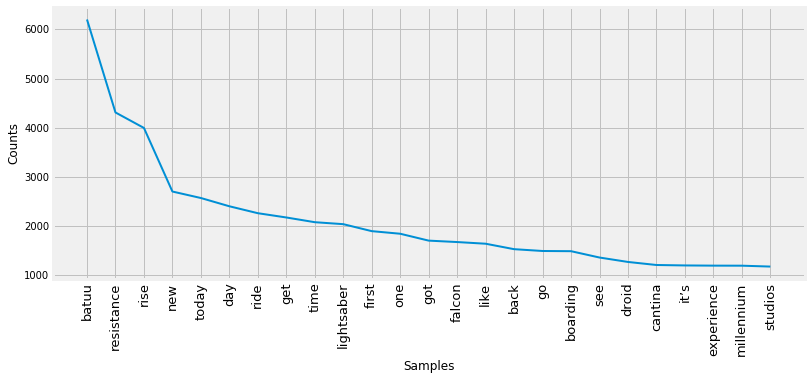

In [26]:
fig = plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(count)
fd.plot(25,cumulative=False)

fig.savefig('images/word_count.png', bbox_inches = "tight")

plt.show()

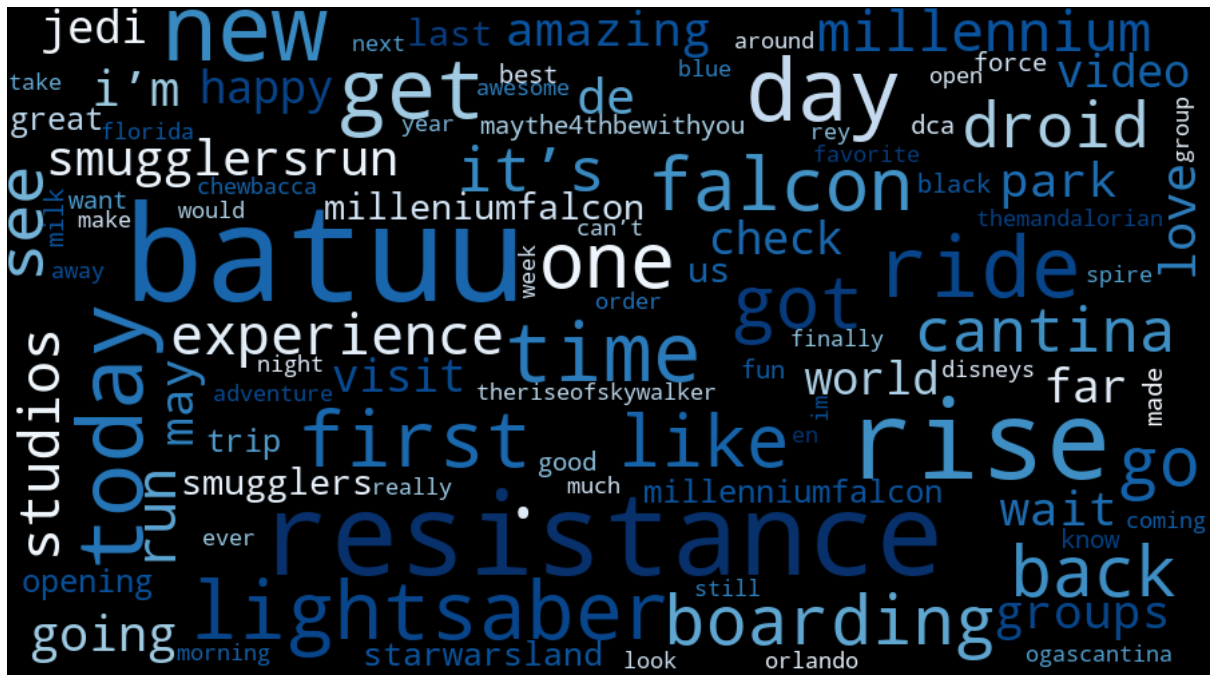

In [27]:
wordfreq = count

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=100,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()

plt.savefig('images/word_cloud.png', dpi=300)

plt.show()

In [28]:
vectorizer = TfidfVectorizer(min_df=4, max_features = 10000)
vz = vectorizer.fit_transform(tweet_df['tweet'])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [29]:
sentiAnalyzer = SentimentIntensityAnalyzer()

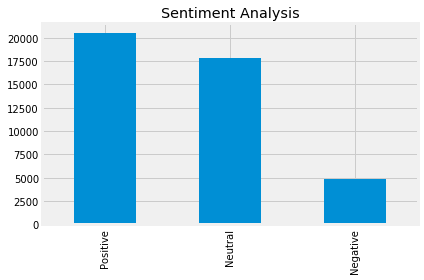

In [30]:
tweet_df['sentiment_compound_polarity']=tweet_df['tweet'].apply(lambda x:sentiAnalyzer.polarity_scores(x)['compound'])
tweet_df['sentiment_neutral']=tweet_df['tweet'].apply(lambda x:sentiAnalyzer.polarity_scores(x)['neu'])
tweet_df['sentiment_negative']=tweet_df['tweet'].apply(lambda x:sentiAnalyzer.polarity_scores(x)['neg'])
tweet_df['sentiment_pos']=tweet_df['tweet'].apply(lambda x:sentiAnalyzer.polarity_scores(x)['pos'])
tweet_df['sentiment_type']=''

tweet_df.loc[tweet_df.sentiment_compound_polarity>0,'sentiment_type']='Positive'
tweet_df.loc[tweet_df.sentiment_compound_polarity==0,'sentiment_type']='Neutral'
tweet_df.loc[tweet_df.sentiment_compound_polarity<0,'sentiment_type']='Negative'

tweet_df.sentiment_type.value_counts().plot(kind='bar',title="Sentiment Analysis")

plt.tight_layout()

plt.savefig('images/sentiment_analysis.png', dpi=300)

plt.show()

In [31]:
positive_tweets = tweet_df.loc[tweet_df['sentiment_type'].str.contains('Positive')]

positive_tweets.head(25)

,date,tweet,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
3,2020-07-15,4 months later hunk junk still sitting herefee...,0.4404,0.775,0.000,0.225,Positive
4,2020-07-15,headed morning disneyworldreopening dont forge...,0.1695,0.886,0.000,0.114,Positive
5,2020-07-15,thinking a woke reboot lucasfilm attempted th...,0.5994,0.702,0.084,0.214,Positive
9,2020-07-14,wish back went opening loved awesome day worth...,0.8807,0.348,0.104,0.548,Positive
11,2020-07-14,see pictures batuu start think fake retouched ...,0.1280,0.677,0.171,0.151,Positive
12,2020-07-14,visit comfort home httpjedinewskjq2y syfywire ...,0.3612,0.706,0.000,0.294,Positive
14,2020-07-14,experience hoping world didnt get starwarstale...,0.4215,0.682,0.000,0.318,Positive
17,2020-07-14,new permit gives us hope ‘star wars’ hotel htt...,0.4404,0.756,0.000,0.244,Positive
19,2020-07-14,mail call thanks colehorton taking trip withou...,0.4404,0.791,0.000,0.209,Positive
20,2020-07-14,aoa honored played lead role bringing life res...,0.9287,0.505,0.000,0.495,Positive


In [32]:
print(str(round((positive_tweets.shape[0]/tweet_df.shape[0])*100, 1))+' %')

47.5 %


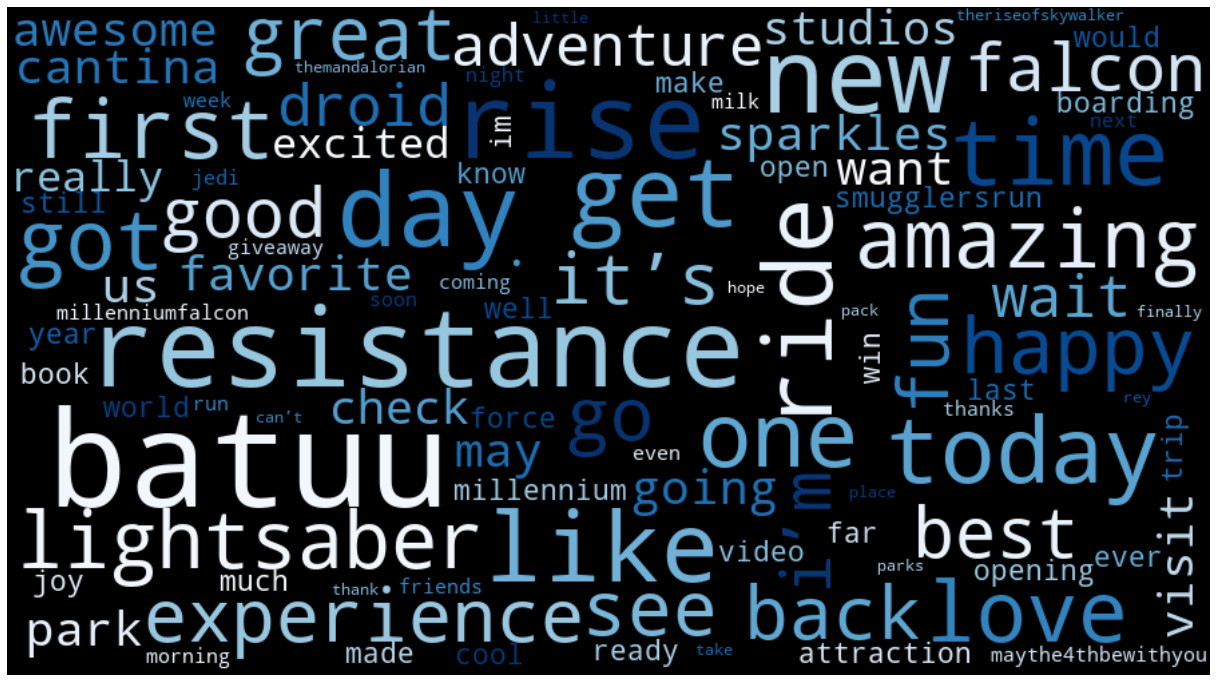

In [33]:
count = Counter()

for text in positive_tweets['tweet'].values:
    for word in text.split():
        count[word] += 1

wordfreq = count

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=100,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()

plt.savefig('images/positive_cloud.png', dpi=300)

plt.show()

In [34]:
neutral_tweets = tweet_df.loc[tweet_df['sentiment_type'].str.contains('Neutral')]

neutral_tweets.head(25)

,date,tweet,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
0,2020-07-15,radio batuu broadcasts music news sports disne...,0.0,1.0,0.0,0.0,Neutral
1,2020-07-15,entrance rise resistance 1030am pictwittercomg...,0.0,1.0,0.0,0.0,Neutral
2,2020-07-15,moment saw mouth dropped open seven years old ...,0.0,1.0,0.0,0.0,Neutral
6,2020-07-15,chewie we’re home dvcrental disneyvacationclub...,0.0,1.0,0.0,0.0,Neutral
7,2020-07-14,2 years ago week model released d23 expo remem...,0.0,1.0,0.0,0.0,Neutral
10,2020-07-14,batuutuesday parked xwing near rise resistance...,0.0,1.0,0.0,0.0,Neutral
13,2020-07-14,savi’s workshop currently sells legacy lightsa...,0.0,1.0,0.0,0.0,Neutral
15,2020-07-14,get xwing’s perspective httpsbitly3j1igby pict...,0.0,1.0,0.0,0.0,Neutral
16,2020-07-14,look east previews land parkwill officially op...,0.0,1.0,0.0,0.0,Neutral
18,2020-07-14,aahhhhhh cant wait open httpstwittercomwdwntst...,0.0,1.0,0.0,0.0,Neutral


In [35]:
print(str(round((neutral_tweets.shape[0]/tweet_df.shape[0])*100, 1))+' %')

41.3 %


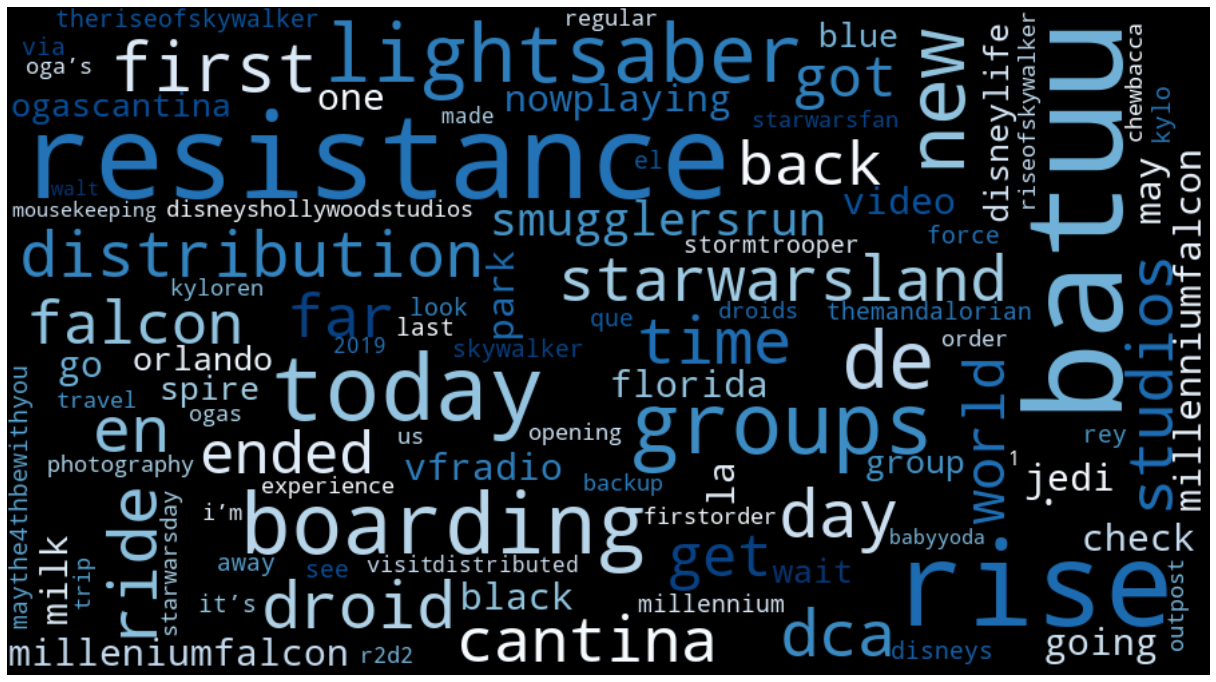

In [36]:
count = Counter()

for text in neutral_tweets['tweet'].values:
    for word in text.split():
        count[word] += 1

wordfreq = count

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=100,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()

plt.savefig('images/neutral_cloud.png', dpi=300)

plt.show()

In [37]:
negative_tweets = tweet_df.loc[tweet_df['sentiment_type'].str.contains('Negative')]
negative_tweets.head(25)

,date,tweet,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
8,2020-07-14,soms ogas getting cut right matt wouldnt want ...,-0.3230,0.751,0.249,0.000,Negative
21,2020-07-14,strict social distancing limited capacity doko...,-0.2263,0.808,0.192,0.000,Negative
29,2020-07-13,custom kyber crystal crafted cores shout refer...,-0.3400,0.789,0.211,0.000,Negative
33,2020-07-13,swgefl smugglers run crew less 6 filling extra...,-0.3400,0.844,0.156,0.000,Negative
34,2020-07-13,swgefl 7132020 cm preview day smugglers run cm...,-0.3400,0.897,0.103,0.000,Negative
35,2020-07-13,swgefl 7132020 cm preview day social distancin...,-0.3400,0.888,0.112,0.000,Negative
43,2020-07-13,reopening wednesday going heres looking forwar...,-0.3400,0.870,0.130,0.000,Negative
59,2020-07-12,year planned go one parks obvious reasons im g...,-0.0516,0.921,0.079,0.000,Negative
70,2020-07-12,missing i’ll go back soon tiktok kyloren storm...,-0.2960,0.784,0.216,0.000,Negative
75,2020-07-12,moisture vaporators batuu anyway isn’t desert ...,-0.4767,0.721,0.279,0.000,Negative


In [38]:
print(str(round((negative_tweets.shape[0]/tweet_df.shape[0])*100, 1))+' %')

11.2 %


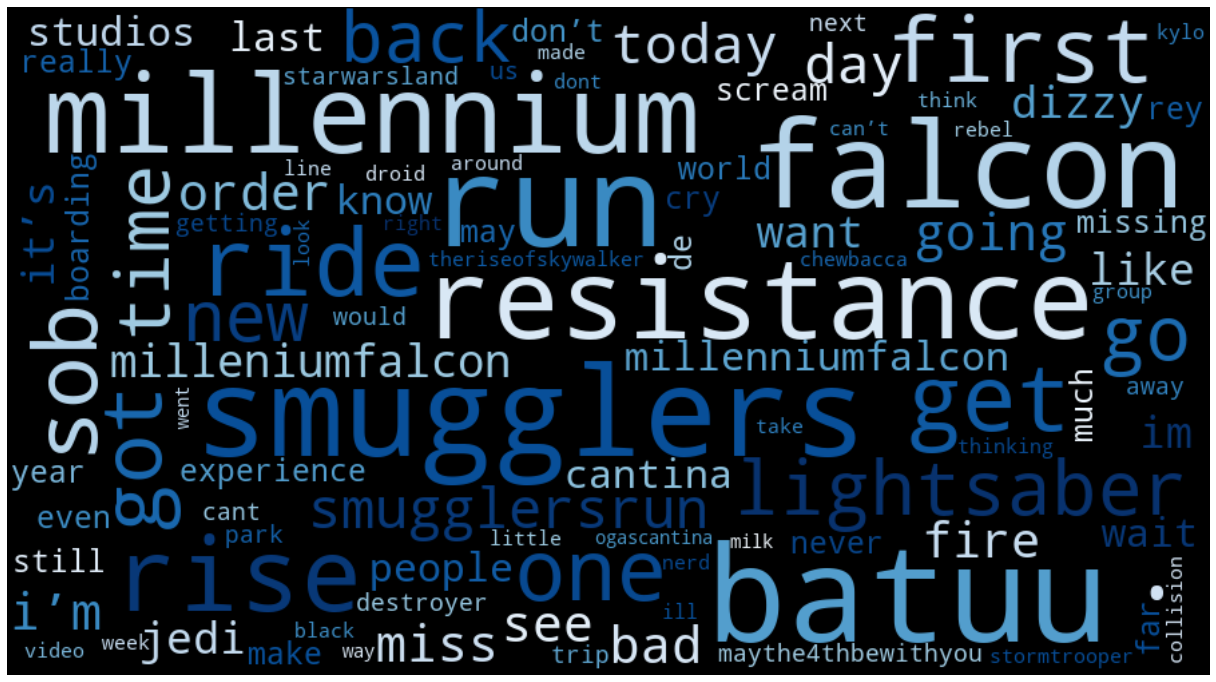

In [39]:
count = Counter()

for text in negative_tweets['tweet'].values:
    for word in text.split():
        count[word] += 1

wordfreq = count

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=100,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()

plt.savefig('images/negative_cloud.png', dpi=300)

plt.show()

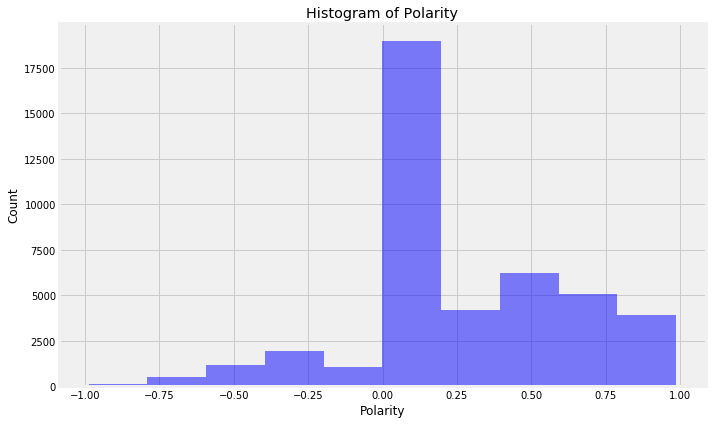

In [40]:
plt.figure(figsize=(10,6))
plt.hist(tweet_df["sentiment_compound_polarity"],
         facecolor='blue', 
         alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Polarity')

plt.tight_layout()

plt.savefig('images/polarity_histogram.png', dpi=300)

plt.show()

In [41]:
daily_sentiment = tweet_df.groupby('date')['sentiment_compound_polarity'].mean()

daily_sentiment.head()

date
2019-10-17    0.134517
2019-10-18    0.206739
2019-10-19    0.236964
2019-10-20    0.227347
2019-10-21    0.242398
Name: sentiment_compound_polarity, dtype: float64

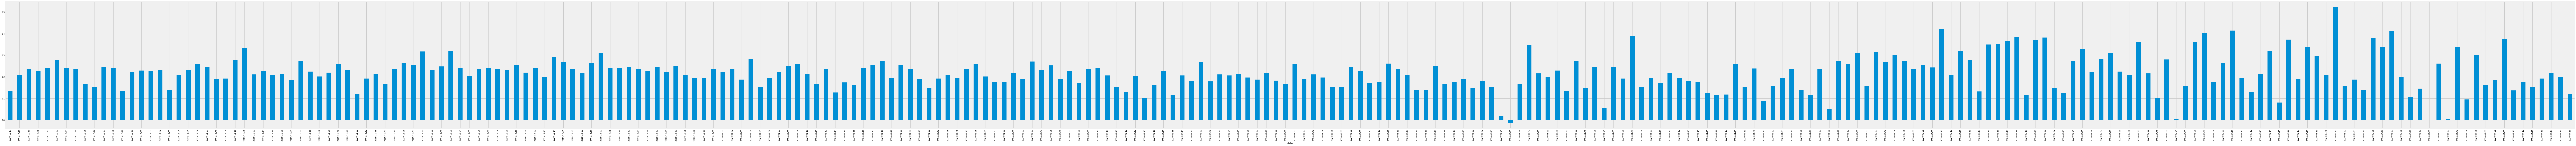

In [45]:
daily_sentiment.plot.bar(figsize=(175,10))

plt.tight_layout()

plt.savefig('images/daily_sentiment.png', dpi=300)